# Building and deploying an XGBoost Hypertension Predictor on AWS SageMaker






## Contents

1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Analysis](#Analysis)
1. [Model Training](#Model_Training)
1. [Deploying the Model to SageMaker Hosting Services](#Deploying_the_Model_to_SageMaker_Hosting_Services)
1. [Model evaluation](#Model_evaluation)
1. [Extensions](#Extensions)

---



## Introduction

This notebook showcases the implementation of the Xgboost algorithm using AWS Sagemaker. This notebook was developed to give a  significant practical and theoretical understanding of the underlying machine learning algorithm. 


### Setup

The goal of this project is to build a Xgboost classification algorithm model to predict the likelihood of hypertension in some patients based on various medical attributes. The logistic regression model will serve a great purpose in the health sector by facilitate early detection and intervention of hypertension.

## Data

The dataset used for this analysis was gotten from kaggle (https://www.kaggle.com/datasets/prosperchuks/health-dataset). The dataset includes the 13 key parameters and a target variable representing whether or not a patient has the disease. Below is the data dictionary:

Age: Patient age

Sex: Gender (1: male; 0: female)

Cp: Chest Pain Type (0: asymptomatic 1: typical angina 2: atypical angina 3: non-anginal pain)

trestbps: Resting Blood Pressure

chol: Cholesterol 

fbs: Fasting Blood Sugar (blood sugar > 120 mg/dl (1: yes; 0: no))

restecg: Resting Electrocardiographic Results (Resting ECG results: 0: normal 1: ST-T wave abnormality )

thalach: Maximum Heart Rate 

exang: Exercise-Induced Angina ((1: yes; 0: no)sss)

oldpeak: ST Depression Induced by Exercise

ca: Number of Major Vessels Colored 

thal: Thalassemia Type:







## Analysis

In [1]:
import pandas as pd

In [2]:
# read in a data using url with pandas
url = 'https://drive.google.com/uc?export=download&id=1YJvfEhq89o-pwgagvj6FbvOIcNYFBf6k'
df = pd.read_csv(url)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,57.0,1.0,3,145,233,1,0,150,0,2.3,0,0,1,1
1,64.0,0.0,2,130,250,0,1,187,0,3.5,0,0,2,1
2,52.0,1.0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56.0,0.0,1,120,236,0,1,178,0,0.8,2,0,2,1
4,66.0,0.0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df.shape

(26083, 14)

In [6]:
df.target.value_counts()

target
1    14274
0    11809
Name: count, dtype: int64

In [7]:
# check for missing values
df.isnull().sum()

age          0
sex         25
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
target       0
dtype: int64

Only the sex column contains missing values in the dataset

Now we will fill the missing values in the sex column with the mode in the column.

In [8]:
# fill missing values in sex with the mode
df['sex'].fillna(df['sex'].mode().iloc[0], inplace=True)

/tmp/ipykernel_14426/2074064668.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sex'].fillna(df['sex'].mode().iloc[0], inplace=True)


In [9]:
# re-check for nulls
df.isnull().sum().sum()

0

All the missing values have been successfully filled. Great! Now we can proceed to train a xgboost classifier using the dataset.

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000,26083.000000
mean,55.661389,0.499521,0.958594,131.592992,246.246061,0.149753,0.526512,149.655024,0.326573,1.039512,1.400299,0.721849,2.318752,0.547253
std,15.189768,0.500009,1.023931,17.588809,51.643522,0.356836,0.525641,22.858109,0.468969,1.165138,0.616513,1.011608,0.604659,0.497772
min,11.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,0.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,67.000000,1.000000,2.000000,140.000000,275.000000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,98.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


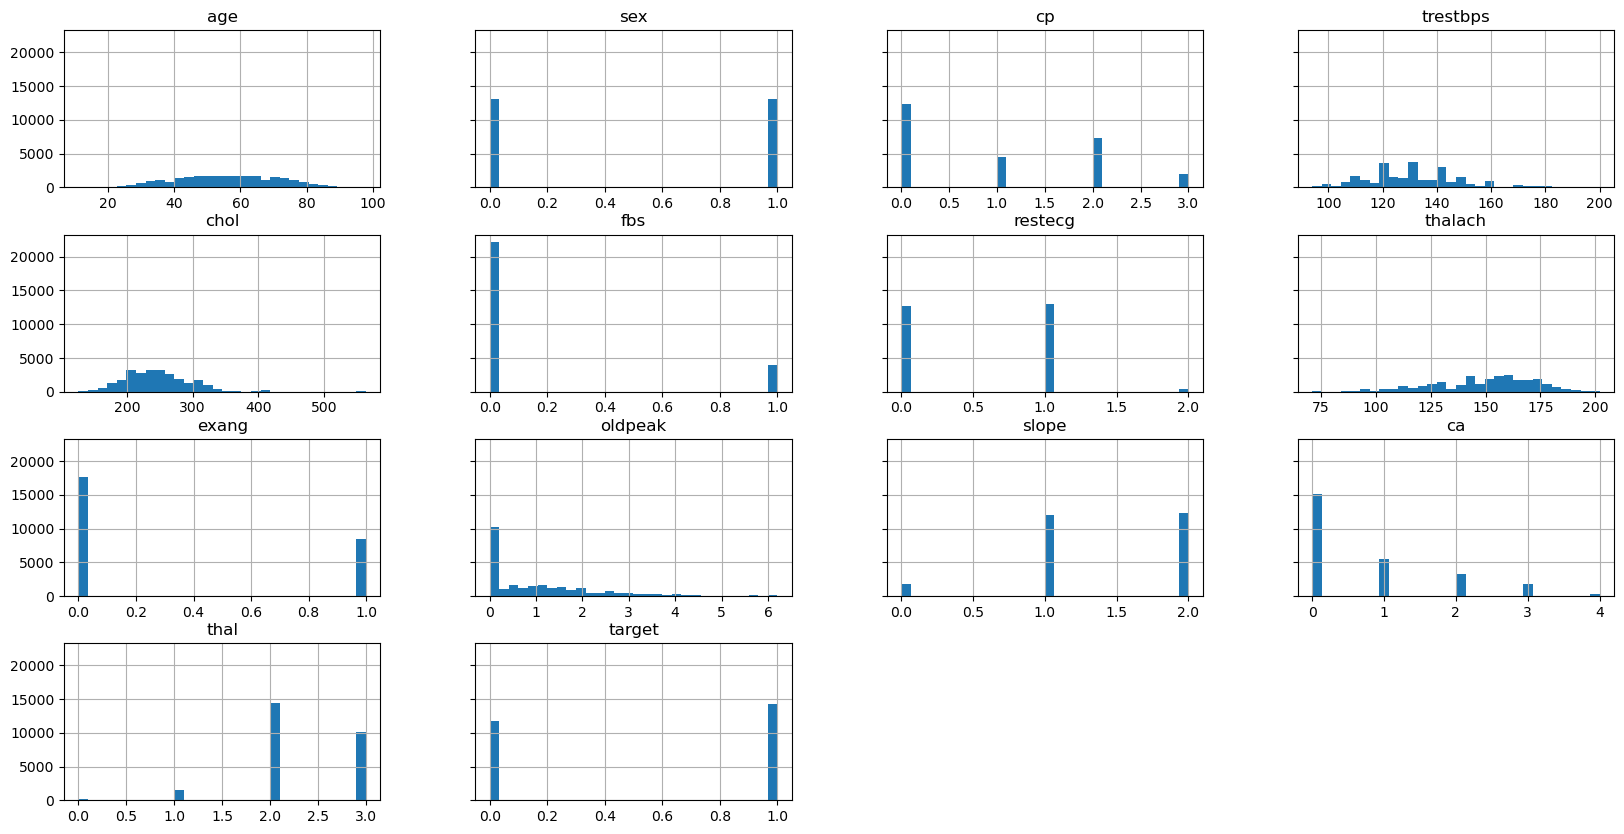

In [11]:
display(df.describe())
hist = df.hist(bins=30, sharey=True, figsize=(20, 10))

In [12]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

# take a copy of the features
features = X.copy()


In [13]:
X

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,57.0,1.0,3,145,233,1,0,150,0,2.3,0,0,1
1,64.0,0.0,2,130,250,0,1,187,0,3.5,0,0,2
2,52.0,1.0,1,130,204,0,0,172,0,1.4,2,0,2
3,56.0,0.0,1,120,236,0,1,178,0,0.8,2,0,2
4,66.0,0.0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26078,72.0,0.0,0,138,294,1,1,106,0,1.9,1,3,2
26079,60.0,1.0,0,144,200,0,0,126,1,0.9,1,0,3
26080,68.0,1.0,0,100,234,0,1,156,0,0.1,2,1,3
26081,67.0,1.0,1,154,232,0,0,164,0,0.0,2,1,2


In [14]:
y

0        1
1        1
2        1
3        1
4        1
        ..
26078    0
26079    0
26080    0
26081    0
26082    0
Name: target, Length: 26083, dtype: int64

Split the dataset into train, validation, and test datasets

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


Using the pandas package, explicitly align each dataset by concatenating the numeric features with the true labels.

In [18]:
import pandas as pd
train = pd.concat([pd.Series(y_train, index=X_train.index,
                             name='target', dtype=int), X_train], axis=1)
validation = pd.concat([pd.Series(y_val, index=X_val.index,
                            name='target', dtype=int), X_val], axis=1)
test = pd.concat([pd.Series(y_test, index=X_test.index,
                            name='target', dtype=int), X_test], axis=1)

In [23]:
train.shape

(15649, 14)

In [19]:
train

,target,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
19492,0,26.0,1.0,3,134,234,0,1,145,0,2.6,1,2,2
14740,0,37.0,0.0,0,132,184,0,0,105,1,2.1,1,1,1
18220,1,42.0,1.0,0,120,354,0,1,163,1,0.6,2,0,2
4874,1,59.0,1.0,1,135,250,0,0,161,0,1.4,1,0,2
818,0,52.0,0.0,0,120,198,0,1,130,1,1.6,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18684,0,72.0,1.0,2,160,269,0,1,112,1,2.9,1,1,3
18846,0,60.0,1.0,0,130,305,0,1,142,1,1.2,1,0,3
10713,1,29.0,1.0,0,115,303,0,1,181,0,1.2,1,0,2
16858,0,62.0,1.0,1,124,261,0,1,141,0,0.3,2,0,3


In [24]:
test.shape

(5217, 14)

In [20]:
test

,target,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
25608,0,74.0,1.0,0,170,225,1,0,146,1,2.8,1,2,1
22223,1,83.0,0.0,2,124,255,1,1,175,0,0.0,2,2,2
1548,1,49.0,0.0,2,130,246,1,0,173,0,0.0,2,3,2
8688,1,49.0,1.0,2,150,243,1,1,137,1,1.0,1,0,2
2937,0,68.0,0.0,0,130,305,0,1,142,1,1.2,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8427,0,52.0,1.0,0,125,212,0,1,168,0,1.0,2,2,3
17655,1,38.0,1.0,1,120,220,0,1,170,0,0.0,2,0,2
3516,1,55.0,1.0,0,120,354,0,1,163,1,0.6,2,0,2
12544,1,71.0,1.0,2,110,265,1,0,130,0,0.0,2,1,2


In [22]:
validation

,target,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
6031,0,55.0,0.0,0,114,318,0,2,140,0,4.4,0,3,1
1781,1,74.0,0.0,2,138,257,0,0,156,0,0.0,2,0,2
17269,0,38.0,0.0,1,130,236,0,0,174,0,0.0,1,1,2
12808,1,68.0,0.0,0,138,243,0,0,152,1,0.0,1,0,2
24502,0,89.0,0.0,1,136,319,1,0,152,0,0.0,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17891,1,62.0,1.0,2,140,211,1,0,165,0,0.0,2,0,2
25270,1,62.0,1.0,0,110,254,0,0,159,0,0.0,2,0,2
2325,1,74.0,0.0,1,130,234,0,0,175,0,0.6,1,0,2
6996,0,50.0,0.0,0,110,275,0,0,118,1,1.0,1,1,2


In [25]:
validation.shape

(5217, 14)

Convert the train and validation dataframe objects to CSV files to match the input file format for the XGBoost algorithm.

In [26]:
# Use 'csv' format to store the data
# The first column is expected to be the output column
train.to_csv('train.csv', index=False, header=False)
validation.to_csv('validation.csv', index=False, header=False)

Using the SageMaker and Boto3, we will upload the training and validation datasets to the default Amazon S3 bucket. The datasets in the S3 bucket will be used by a compute-optimized SageMaker instance on Amazon EC2 for training.

The following code sets up the default S3 bucket URI for your current SageMaker session, creates a new sagemaker/xgboost-hypertension-prediction folder, and uploads the training and validation datasets to the data subfolder.

In [27]:
import sagemaker, boto3, os
bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/xgboost-hypertension-prediction"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/validation.csv')).upload_file('validation.csv')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


To check if the CSV files are successfully uploaded to the S3 bucket, we will run this code

In [28]:
! aws s3 ls {bucket}/{prefix}/data --recursive

2024-09-03 15:19:39     641094 sagemaker/xgboost-hypertension-prediction/data/train.csv
2024-09-03 15:19:40     213736 sagemaker/xgboost-hypertension-prediction/data/validation.csv


## Model Training

To obtain the current AWS Region where the SageMaker notebook instance is running, and the current  IAM role used by the notebook instance.

In [50]:
import sagemaker

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

AWS Region: us-east-1
RoleArn: arn:aws:iam::020204352844:role/service-role/AmazonSageMaker-ExecutionRole-20240903T131905


Next, we will create an XGBoost estimator using the sagemaker.estimator.Estimator class. In the following example code, the XGBoost estimator is named xgb_model.

In [51]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.session import TrainingInput

s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model')

container=sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")
print(container)

xgb_model=sagemaker.estimator.Estimator(
    image_uri=container,
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    volume_size=5,
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session(),
    rules=[
        Rule.sagemaker(rule_configs.create_xgboost_report()),
        ProfilerRule.sagemaker(rule_configs.ProfilerReport())
    ]
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


Next, we will set the hyperparameters for the XGBoost algorithm by calling the set_hyperparameters method of the estimator. 

In [68]:
xgb_model.set_hyperparameters(
    max_depth = 3,
    eta = 0.2,
    gamma = 4,
    min_child_weight = 6,
    subsample = 0.7,
    objective = "binary:logistic",
    num_round = 10
)

Now, we will use the TrainingInput class to configure a data input flow for training from the data we stored in S3 earlier

In [77]:
from sagemaker.session import TrainingInput

train_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/train.csv"), content_type="csv"
)
validation_input = TrainingInput(
    "s3://{}/{}/{}".format(bucket, prefix, "data/validation.csv"), content_type="csv"
)

To start model training, call the estimator's fit method with the training and validation datasets.

In [78]:
xgb_model.fit({"train": train_input, "validation": validation_input}, wait=True)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-09-03-16-40-27-703


2024-09-03 16:40:30 Starting - Starting the training job...
2024-09-03 16:40:53 Starting - Preparing the instances for trainingCreateXgboostReport: InProgress
ProfilerReport: InProgress
...
2024-09-03 16:41:33 Downloading - Downloading input data...
2024-09-03 16:41:53 Downloading - Downloading the training image......
2024-09-03 16:43:04 Training - Training image download completed. Training in progress.
2024-09-03 16:43:04 Uploading - Uploading generated training model
2024-09-03 16:43:04 Completed - Training job completed
[2024-09-03 16:42:46.894 ip-10-2-124-40.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm

We will now try to specify the S3 bucket URI where the Debugger training reports are generated and check if the reports exist.

In [79]:
rule_output_path = xgb_model.output_path + "/" + xgb_model.latest_training_job.job_name + "/rule-output"
! aws s3 ls {rule_output_path} --recursive

2024-09-03 16:43:12        316 sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
2024-09-03 16:43:12        734 sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
2024-09-03 16:43:12       2483 sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json
2024-09-03 16:43:12        982 sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/IterativeClassAccuracy.json
2024-09-03 16:43:12        178 sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/LabelsDistribution.j

Next we will download the Debugger XGBoost training and profiling reports to the current workspace:

In [80]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-020204352844/sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/EvaluationMetrics.json to CreateXgboostReport/xgboost-reports/EvaluationMetrics.json
download: s3://sagemaker-us-east-1-020204352844/sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/ConfusionMatrix.json to CreateXgboostReport/xgboost-reports/ConfusionMatrix.json
download: s3://sagemaker-us-east-1-020204352844/sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgboostReport/xgboost-reports/FeatureImportance.json to CreateXgboostReport/xgboost-reports/FeatureImportance.json
download: s3://sagemaker-us-east-1-020204352844/sagemaker/xgboost-hypertension-prediction/xgboost_model/sagemaker-xgboost-2024-09-03-16-40-27-703/rule-output/CreateXgb

We will attempt to get the file link of the XGBoost training report as follows:

In [81]:
from IPython.display import FileLink, FileLinks
display("Click link below to view the XGBoost Training report", FileLink("CreateXgboostReport/xgboost_report.html"))

'Click link below to view the XGBoost Training report'

/home/ec2-user/SageMaker/xgboost_customer_churn_2024-09-03/CreateXgboostReport/xgboost_report.html

## Deploying the Model to SageMaker Hosting Services

In [82]:
import sagemaker
from sagemaker.serializers import CSVSerializer
xgb_predictor=xgb_model.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-09-03-16-48-50-082
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-09-03-16-48-50-082
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-09-03-16-48-50-082


------------!

In [83]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2024-09-03-16-48-50-082'

## Model evaluation

For the model evaluation, we will set up the following function to predict each line of the test set

In [84]:
import numpy as np
def predict(data, rows=1000):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])
    return np.fromstring(predictions[1:], sep=',')

Now we will make predictions of the test dataset and plot a histogram

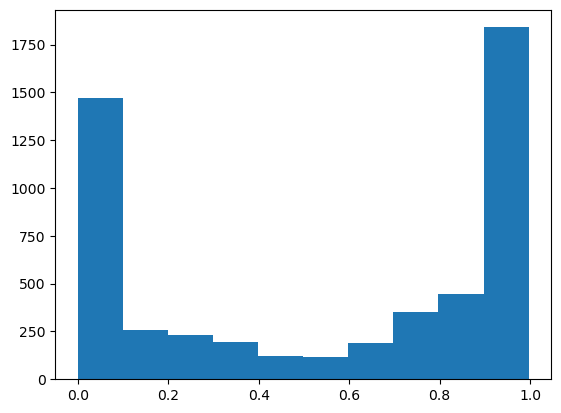

In [85]:
import matplotlib.pyplot as plt

predictions=predict(test.to_numpy()[:,1:])
plt.hist(predictions)
plt.show()

In [86]:
import sklearn

cutoff=0.5
print(sklearn.metrics.confusion_matrix(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(test.iloc[:, 0], np.where(predictions > cutoff, 1, 0)))

[[2248  146]
 [  30 2793]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      2394
           1       0.95      0.99      0.97      2823

    accuracy                           0.97      5217
   macro avg       0.97      0.96      0.97      5217
weighted avg       0.97      0.97      0.97      5217



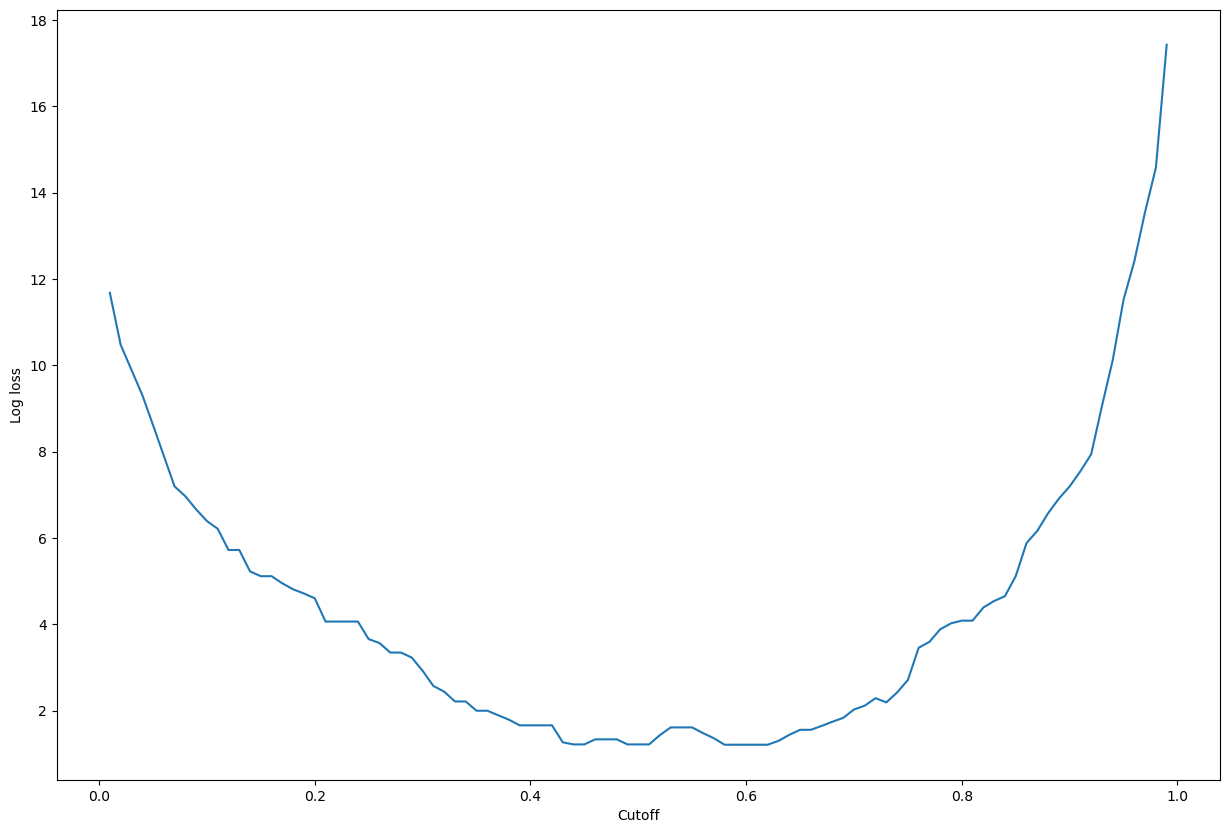

In [87]:
import matplotlib.pyplot as plt

cutoffs = np.arange(0.01, 1, 0.01)
log_loss = []
for c in cutoffs:
    log_loss.append(
        sklearn.metrics.log_loss(test.iloc[:, 0], np.where(predictions > c, 1, 0))
    )

plt.figure(figsize=(15,10))
plt.plot(cutoffs, log_loss)
plt.xlabel("Cutoff")
plt.ylabel("Log loss")
plt.show()

In [88]:
print(
    'Log loss is minimized at a cutoff of ', cutoffs[np.argmin(log_loss)], 
    ', and the log loss value at the minimum is ', np.min(log_loss)
)

Log loss is minimized at a cutoff of  0.5800000000000001 , and the log loss value at the minimum is  1.2090548865431288


Next, we'll import the Python libraries we'll need for the remainder of the example.

In [89]:
xgb_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2024-09-03-16-48-50-082
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2024-09-03-16-48-50-082


In [90]:
xgb_predictor.endpoint_name

'sagemaker-xgboost-2024-09-03-16-48-50-082'

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/introduction_to_applying_machine_learning|xgboost_customer_churn|xgboost_customer_churn.ipynb)
